In [38]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
%matplotlib inline
import time
import sqlite3
import pandas as pd
from scipy.interpolate import interp1d
import random 
from datetime import datetime
plt.style.use('ggplot')

## Datas 
Zuwa, I started this part but please can you finc the distribution of those data depending on what we need for the problem + generate random data ?
You might also have to clean the data

In [2]:
DATA_PATH = '/Users/mathildebadoual/code/ecoblock_test/data/database.sqlite'

In [3]:
def import_load_demand(sim_number, sim_id):
    conn = sqlite3.connect(DATA_PATH)
    cur = conn.cursor()
    sql_script = ('SELECT demand FROM results WHERE simulation_id = ? AND simulation_num = ?')
    cur.execute(sql_script, (str(sim_id), str(sim_number)))
    load_demand = cur.fetchall()
    conn.close()
    return np.array(load_demand)

def import_ev_demand(sim_number, sim_id):
    conn = sqlite3.connect(DATA_PATH)
    cur = conn.cursor()
    sql_script = ('SELECT ev_demand FROM results WHERE simulation_id = ? AND simulation_num = ?')
    cur.execute(sql_script, (str(sim_id), str(sim_number)))
    ev_demand = cur.fetchall()
    conn.close()
    return np.array(ev_demand)

def import_pv_generation(sim_number, sim_id):
    conn = sqlite3.connect(DATA_PATH)
    cur = conn.cursor()
    sql_script = ('SELECT pv_generation FROM results WHERE simulation_id = ? AND simulation_num = ?')
    cur.execute(sql_script, (str(sim_id), str(sim_number)))
    pv_generation = cur.fetchall()
    conn.close()
    return np.array(pv_generation)

In [4]:
data = pd.read_csv('price_demand.csv')
data.max()

Year       2015.000
Month        12.000
day          31.000
Hour         24.000
Demand    23169.960
Price       187.891
dtype: float64

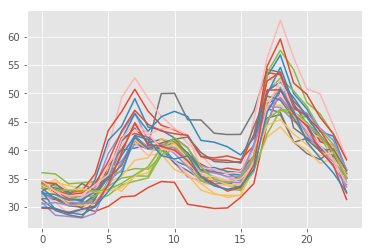

In [5]:
for day in range(1, 31):
    for month in range(1, 2):
        plt.plot(range(0, 24), data[(data['day'] == day) & (data['Month'] == month) & (data['Year'] == 2013)]['Price'])

## Markov Chain: EV data

In [7]:
data_ev = pd.read_csv('EV_data.csv')
ID_26 = data_ev['ID:26']     #Car_ID:26
ID_370 = data_ev['ID:370']   #Car_ID:370
ID_545 = data_ev['ID:545']   #Car_ID:545
ID_661 = data_ev['ID:661']   #Car_ID:661
ID_4767 = data_ev['ID:4767'] #Car_ID:4767

#Creating and resizing EV_array into (ID , Week, DOW, HOD)
ev_array = np.array([ID_26, ID_370, ID_545, ID_661, ID_4767])
ev_array.resize(5,47,7,24)

In [12]:
array = np.zeros((len(data.columns[1:])*len(data_ev), 5))
j = 0
for car_index, car in enumerate(data_ev.columns[1:]):
    for i in range(len(data_ev)):
        value = datetime.strptime(data_ev['localminute'].iloc[i], '%m/%d/%Y %H:%M')
        week_of_year = int(value.strftime('%W'))
        day_of_week = int(value.strftime('%w'))
        hour_of_day = int(value.strftime('%H'))
        array[j, :] = [car_index, week_of_year, day_of_week, hour_of_day, data_ev[car].iloc[i]]
        j += 1
        
data_ev_resized = pd.DataFrame(array, columns=['car_index', 'week_of_year', 'day_of_week', 'hour_of_day', 'energy_consumption'])

In [13]:
presence_list = []
for element in data_ev_resized['energy_consumption']:
    if element <= 0.01:
        presence_list.append(0)
    else:
        presence_list.append(1)
        
data_ev_resized['presence'] = presence_list


In [14]:
#Creating Markov chain!
#Considering (5 x 47 x 7 ) different data arrays, we find the probablility
#matrix pij(k), i for charging, j for not charging.
#At each time step we count the 
p_list =[ ]  #initializing list containing the probability matrices
for k in range(23):  # 23 cuz probability doesn't count for last timestep
    Num_charging = [0, 0, 0]     #[num_charging now, num_STILL charging at k+1, num_n0t charging at k+1]
    Num_not_charging = [0, 0, 0] #[num_not charging now, num_charging next k, num STILL not charging next k]
    for j in range(47):
        for v in range(7):
            if any(i >= 0.3 for i in ev_array[:,j,v,k]): #I use 0.3 as charging benchmark
                Num_charging[0] += 1
                if any(i >= 0.3 for i in ev_array[:,j,v,k+1]):
                    Num_charging[1] += 1
                else:
                    Num_charging[2] += 1
            else:
                Num_not_charging[0] += 1
                if any(i >= 0.3 for i in ev_array[:,j,v,k+1]):
                    Num_not_charging[1] += 1
                else:
                    Num_not_charging[2] += 1
    p_ij = np.zeros((2,2))
    p_ij[0,0] = Num_charging[1]/Num_charging[0]  #probability of moving from i to i
    p_ij[0,1] = Num_charging[2]/Num_charging[0]  #probability of moving from i to j
    p_ij[1,0] = Num_not_charging[1]/Num_not_charging[0] 
    p_ij[1,1] = Num_not_charging[2]/Num_not_charging[0]
    p_list.append(p_ij)
    

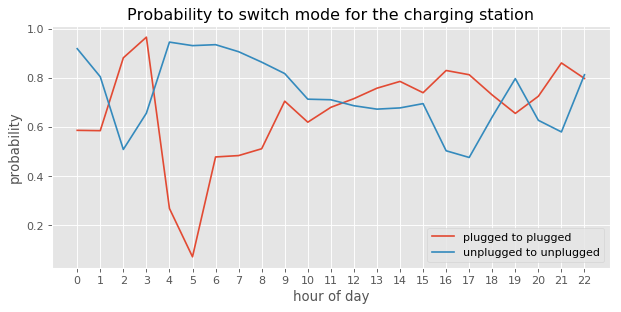

In [15]:
P = np.array(p_list)
fs = 14

plt.figure(dpi = 80, figsize = (9,4), tight_layout = False)
plt.plot(np.linspace(0,22,23), P[:,0,0], label = 'plugged to plugged')
plt.plot(np.linspace(0,22,23), P[:,1,1], label = 'unplugged to unplugged')
plt.xticks(np.linspace(0,22,23))
plt.ylabel('probability', fontsize = fs-2)
plt.xlabel('hour of day', fontsize = fs-2)
plt.title('Probability to switch mode for the charging station')
plt.legend()
plt.show()

## Regular DeterministicControl

In [16]:
## SET PARAMETERS
num_station = 2
ns = 10

N = 24
c = 100
alpha = 0.003
delta_t = 10/N
u_max = 0.3
u_tot_max = 0.03

In [17]:
def satisfaction_function(x):
    return c * (1 - np.exp(alpha * (1 - x)))/(1 - np.exp(alpha))

In [55]:
## GET DATA
prices_day = data[(data['day'] == 1) & (data['Month'] == 1) & (data['Year'] == 2013)]['Price']
prices_interp = interp1d(np.linspace(0, 23, 24), prices_day)
prices = np.flip(prices_interp(np.linspace(0, 23, N)), axis=0)
#prices = prices_interp(np.linspace(0, 23, N))

In [56]:
import itertools
SOC_grid = np.array(list(itertools.product(np.linspace(0, 1, ns), np.linspace(0, 1, ns))))
SOC_grid[-1, :]

array([1., 1.])

In [47]:
u_star = np.zeros((num_station, len(SOC_grid), N))
V = np.inf * np.ones((num_station, len(SOC_grid), N+1))
V[:, :, N] = satisfaction_function(SOC_grid.T)

In [48]:
## SOLVE DYNAMIC PROGRAM
start = time.time()

# Boundary Condition of Value Function (Principle of Optimality)
#V[:, :, N] = np.zeros((num_station, len(SOC_grid)))

# Iterate backward in time
for k in range(N-1, 0, -1):

    # Iterate over SOC
    for idx in range(0, len(SOC_grid)):

        # Find dominant bounds for u_batt
        lb = 0
        ub = [min(u_max, (1 - SOC_grid[idx, i])/delta_t) for i in range(num_station)]
        
        # Grid Battery Power between dominant bounds
        u_batt_grid = np.array(list(itertools.product(np.linspace(lb, ub[0], ns), np.linspace(lb, ub[1], ns))))
        #TODO: enlever ceux qui ne respectent pas sum(u_i) <= Umax
        
        # compute next SOC using dynamics
        SOC_nxt = SOC_grid[idx] + delta_t * u_batt_grid
        
        # Cost of satisfaction
        #satisfaction_k = np.array([np.sum(satisfaction_function(SOC_nxt[i, :])) for i in range(SOC_nxt.shape[0])])
        g_k = prices[k] * np.array([np.sum(u_batt_grid[i, :]) for i in range(SOC_grid.shape[0])]) #+ satisfaction_k
        
        # Compute value function at nxt time step (need to interpolate)
        V_nxt = np.reshape(interp(SOC_nxt.flatten(), SOC_grid.flatten(), V[:, :, k+1].flatten()), (num_station, len(SOC_grid)))
        
        # Value Function (Principle of Optimality)
        V[:, idx, k] = (delta_t * g_k + V_nxt).min(axis=1)
        ind = np.argmin(delta_t * g_k + V_nxt, axis=1)
        
        # Save Optimal Control
        u_star[:, idx, k] = u_batt_grid[ind[0]]
        
# DP Timer
end = time.time()
print(str(end - start) + " seconds")

1.26837158203125 seconds


In [49]:
## Simulate Results

# Preallocate
SOC_sim = np.zeros((num_station, N))
u_batt_sim = np.zeros((num_station, N))
J_sim = np.zeros((N))

# Initialize
SOC_0 = np.array([0.5, 0.1])
SOC_sim[:, 0] = SOC_0

# Simulate PHEV Dynamics
for k in range(0, N-1):
    
    # Use optimal battery power, for given SOC
    u_batt_sim[:, k] = np.reshape(interp(SOC_sim[:, k].flatten(), SOC_grid.flatten(), u_star[:, :, k].flatten()), (num_station,))
    
    # Fuel Consumption
    satisfaction_k = np.sum(c * (1 - np.exp(alpha * (1 - SOC_sim[:, k])))/(1 - np.exp(alpha)))
    J_sim[k] = prices[k] * np.sum(u_batt_sim[:, k]) + satisfaction_k
    
    # Time-step SOC dynamics
    SOC_sim[:, k+1] = SOC_sim[:, k] + delta_t * u_batt_sim[:, k]

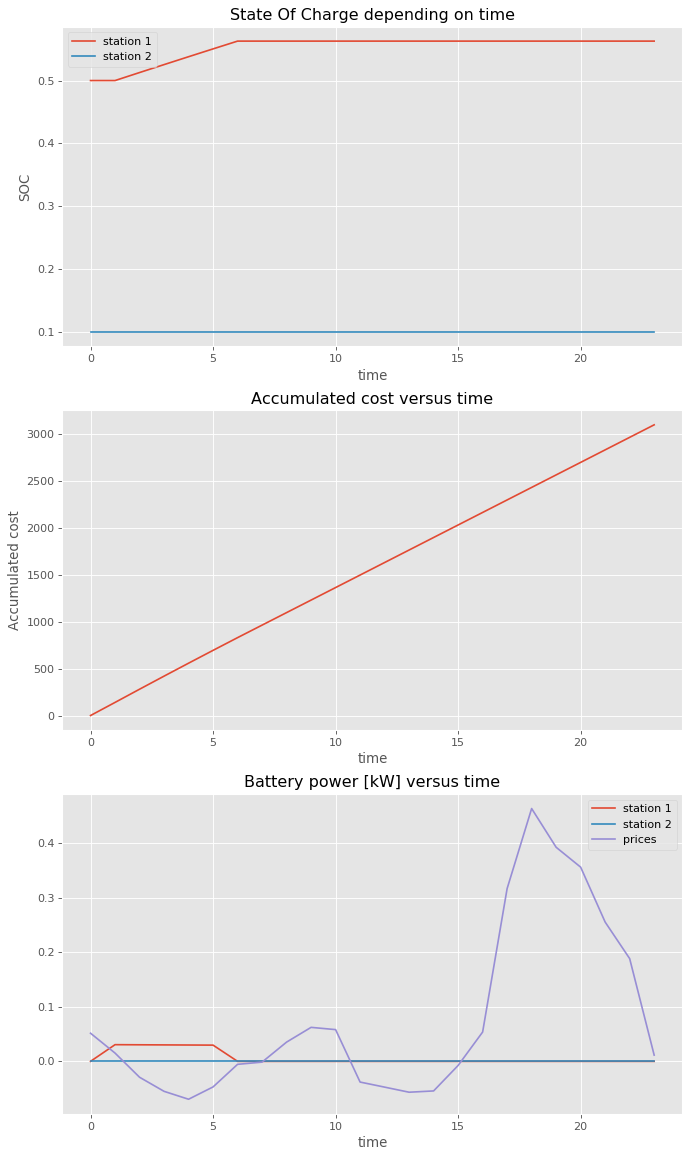

In [50]:
t = np.linspace(0, 23, N)

## Plot Simulation Results
plt.figure(num=3, figsize=(10, 18), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(3,1,1)
plt.plot(t, SOC_sim[0], label='station 1')  
plt.plot(t, SOC_sim[1], label='station 2') 
#plt.plot(t, SOC_sim[2], label='station 3')  
plt.title('State Of Charge depending on time')
plt.xlabel('time')
plt.ylabel('SOC')
plt.legend()
# SOC versus time

plt.subplot(3,1,2)
plt.plot(t, [np.sum(J_sim[:k]) for k in range(0, N)])  # plot speed
plt.title('Accumulated cost versus time')
plt.xlabel('time')
plt.ylabel('Accumulated cost')
# Accumulated fuel consumption [g] versus time

plt.subplot(3,1,3)
plt.plot(t, u_batt_sim[0], label='station 1')  
plt.plot(t, u_batt_sim[1], label='station 2') 
#plt.plot(t, u_batt_sim[2], label='station 3') 
plt.plot(t, prices/40 - 0.8, label='prices')
plt.title('Battery power [kW] versus time')
plt.xlabel('time')
plt.legend()
# Battery and engine power [kW] versus time

plt.savefig('results.png')

## Stochastic Control

In [57]:
## SET PARAMETERS
num_station = 2
ns = 10

N = 24
c = 100
alpha = 0.01
delta_t = 10/N
u_max = 0.3
u_tot_max = 0.03

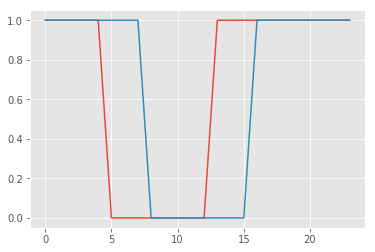

In [68]:
## GET DATA
prices_day = data[(data['day'] == 1) & (data['Month'] == 1) & (data['Year'] == 2013)]['Price']
prices_interp = interp1d(np.linspace(0, 23, 24), prices_day)
#prices = prices_interp(np.linspace(0, 23, N))
prices = np.flip(prices_interp(np.linspace(0, 23, N)), axis=0)

presence = np.zeros((num_station, 24))
#presence[i, :] = data_ev_resized[(data_ev_resized['car_index'] == 1) & (data_ev_resized['day_of_week'] == i+1) & (data_ev_resized['week_of_year'] == 15)]['presence']
presence[0, :] = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
presence[1, :] = np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
plt.plot(presence[0, :])
plt.plot(presence[1, :])

In [75]:
SOC_shape = tuple([ns for i in range(num_station)])   # This creates a tuple is needed to for any np.reshape operation later

SOC_grid = np.array(list(itertools.product(np.linspace(0, 1, ns), repeat = num_station))) # repeat added...

SOC_tuple = tuple([np.linspace(0,1,ns) for i in range(num_station)])  # This is needed for the interpolation later

In [76]:
u_star = np.zeros((num_station, len(SOC_grid), N))
V = 10000000 * np.ones((len(SOC_grid), N+1))
V[ :, N] = satisfaction_function(SOC_grid[:,0]) + satisfaction_function(SOC_grid[:,1])

In [77]:
## SOLVE DYNAMIC PROGRAM
start = time.time()

# Boundary Condition of Value Function (Principle of Optimality)
# V[:, :, N] = np.zeros((num_station, len(SOC_grid)))

# Iterate backward in time
for k in range(N-1, 0, -1):

    # Iterate over SOC
    for idx in range(0, len(SOC_grid)):

        # Find dominant bounds for u_batt
        # Find dominant bounds for u_batt
        lb = 0
        ub = [min(u_max, (1.0 - SOC_grid[idx, i])/delta_t) for i in range(num_station)]
        
        # Grid Battery Power between dominant bounds
        u_batt_init = np.array(list(itertools.product(np.linspace(lb, u_max, ns), repeat = num_station))) #initializing u_batt
        u_batt_init = u_batt_init * ub/u_max  #This ensures that the upperbounds are respected if ub < u_max
        
        u_batt_del = u_batt_init.sum(axis = 1) > u_max
        u_batt_grid = u_batt_init[(u_batt_del == False)]
        #This is the real u_batt_grid used in the rest of the code
        #TODO: enlever ceux qui ne respectent pas sum(u_i) <= Umax
        
        # compute next SOC using dynamics
        SOC_nxt_00 = 0 * u_batt_grid
        SOC_nxt_11 = SOC_grid[idx] + delta_t * u_batt_grid
        SOC_nxt_01 = random.uniform(0, 1) * np.ones(u_batt_grid.shape)# tbd
        SOC_nxt_10 = 0 * u_batt_grid
        
        # Cost of satisfaction
        satisfaction_k = np.array([np.sum(c * (1 - np.exp(alpha * (1 - SOC_nxt_11[i, :])))/(1 - np.exp(alpha))) for i in range(u_batt_grid.shape[0])])
        g_k = prices[k] * np.array([np.sum(u_batt_grid[i, :]) for i in range(u_batt_grid.shape[0])]) + satisfaction_k
        
        
        # Compute value function at nxt time step (need to interpolate)
        
        V_nxt_init = 10000000*np.ones((len(SOC_nxt),1)) #initializing V_nxt
        V_temp = V[:,k+1].reshape(SOC_shape)      #V[k+1] has to be reshaped to work in interpolation
        V_interp_function = RegularGridInterpolator(SOC_tuple, V_temp, method = 'linear')  #n-dimensional interpolation function
        
        V_nxt_00 = V_interp_function(SOC_nxt_00)
        V_nxt_11 = V_interp_function(SOC_nxt_11)
        V_nxt_01 = V_interp_function(SOC_nxt_01)
        V_nxt_10 = V_interp_function(SOC_nxt_10)
                
        if k == 23:
            V_nxt = V_nxt_11
        else:
            V_nxt = P[k, 0, 0] * V_nxt_00 + P[k, 1, 1] * V_nxt_11 + P[k, 0, 1] * V_nxt_01 + P[k, 1, 0] * V_nxt_10
        
        # Value Function (Principle of Optimality)
        V[idx, k] = (delta_t * g_k + V_nxt).min()
        ind = np.argmin(delta_t * g_k + V_nxt)
        
        # Save Optimal Control
        u_star[:, idx, k] = u_batt_grid[ind]
        
# DP Timer
end = time.time()
print(str(end - start) + " seconds")

4.959184646606445 seconds


In [78]:
## Simulate Results

random.seed(10)

# Preallocate
SOC_sim = np.zeros((num_station, N))
u_batt_sim = np.zeros((num_station, N))
J_sim = np.zeros((N))

# Initialize
SOC_0 = np.array([0.5, 0.1])
SOC_sim[:, 0] = SOC_0

# Simulate PHEV Dynamics
for k in range(0, N-1):
    
#     # Use optimal battery power, for given SOC
#     u_batt_sim[:, k] = np.reshape(interp(SOC_sim[:, k].flatten(), SOC_grid.flatten(), u_star[:, :, k].flatten()), (num_station,))
#     for i in range(num_station):
#         u_batt_sim[i, k] = presence[i, k] * u_batt_sim[i, k]
    
    # Use optimal battery power, for given SOC
    for i in range(num_station):
        u_temp_sim = u_star[i,:,k].reshape(SOC_shape)
        u_interp_func= RegularGridInterpolator(SOC_tuple, u_temp_sim, method = 'linear') 
        u_batt_sim[i, k] = presence[i,k] * u_interp_func(SOC_sim[:,k])      #interpolation necessary for selectign each element of u_batt_sim!
        
    # Fuel Consumption
    satisfaction_k = np.sum(c * (1 - np.exp(alpha * (1 - SOC_sim[:, k])))/(1 - np.exp(alpha)))
    J_sim[k] = prices[k] * np.sum(u_batt_sim[:, k]) + satisfaction_k
    
    # Time-step SOC dynamics
    SOC_sim[:, k+1] = (SOC_sim[:, k] + delta_t * u_batt_sim[:, k])
    
    for i in range(num_station):
        if presence[i, k] == 0 and presence[i, k+1] == 1:
            print('switch')
            SOC_sim[i, k+1] = random.uniform(0, 1)
        else:
            SOC_sim[i, k+1] = presence[i, k] * SOC_sim[i, k+1]

switch
switch


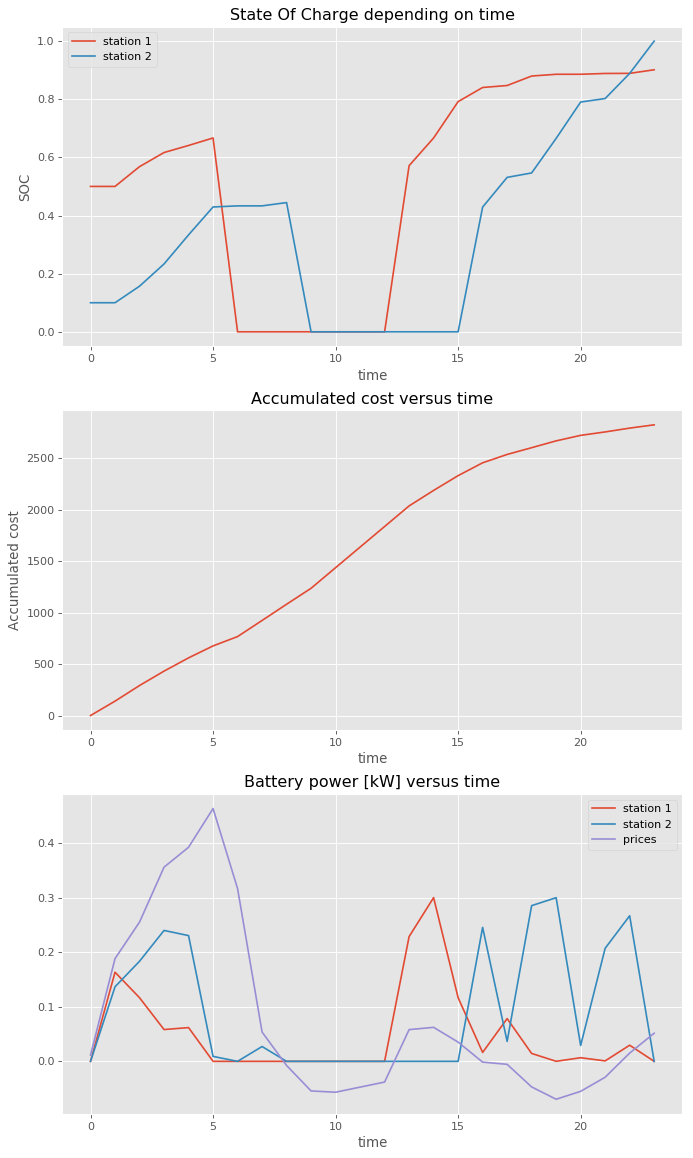

In [79]:
t = np.linspace(0, 23, N)

## Plot Simulation Results
plt.figure(num=3, figsize=(10, 18), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(3,1,1)
plt.plot(t, SOC_sim[0], label='station 1')  
plt.plot(t, SOC_sim[1], label='station 2') 
#plt.plot(t, SOC_sim[2], label='station 3')  
plt.title('State Of Charge depending on time')
plt.xlabel('time')
plt.ylabel('SOC')
plt.legend()
# SOC versus time

plt.subplot(3,1,2)
plt.plot(t, [np.sum(J_sim[:k]) for k in range(0, N)])  # plot speed
plt.title('Accumulated cost versus time')
plt.xlabel('time')
plt.ylabel('Accumulated cost')
# Accumulated fuel consumption [g] versus time

plt.subplot(3,1,3)
plt.plot(t, u_batt_sim[0], label='station 1')  
plt.plot(t, u_batt_sim[1], label='station 2') 
#plt.plot(t, u_batt_sim[2], label='station 3') 
plt.plot(t, prices/40 - 0.8, label='prices')
plt.title('Battery power [kW] versus time')
plt.xlabel('time')
plt.legend()
# Battery and engine power [kW] versus time

plt.savefig('results_mpc.png')